# Bibliotecas

In [ ]:
# Instala bibliotecas
!pip install requests

In [1]:
# Importa bibliotecas
import requests
import pandas as pd
import numpy as np

# Coleta de dados

In [3]:
# Códigos IBGE dos entes federativos para a análise
codigos_entes = pd.DataFrame(
    requests.get("https://apidatalake.tesouro.gov.br/ords/siconfi/tt/entes")
    .json()["items"]
    ).query("esfera in ['U', 'E']")
codigos_entes

,cod_ibge,ente,capital,regiao,uf,esfera,exercicio,populacao,cnpj
146,17,Tocantins,0,CO,BR,E,2022,1607363,01786029000103
1621,1,União,0,BR,None,U,2022,8569324,None
1622,11,Rondônia,0,NO,BR,E,2022,1815278,00394585000171
1623,12,Acre,0,NO,BR,E,2022,906876,63606479000124
1624,13,Amazonas,0,NO,BR,E,2022,4269995,04312369000190
1625,14,Roraima,0,NO,BR,E,2022,652713,84012012000126
1626,15,Pará,0,NO,BR,E,2022,8777124,05054861000176
1627,16,Amapá,0,NO,BR,E,2022,877613,00394577000125
1628,21,Maranhão,0,NE,BR,E,2022,7153262,06354468000160
1629,22,Piauí,0,NE,BR,E,2022,3289290,06553481000149


In [ ]:
# Coleta de dados do SICONFI
# DGA - Declaração de contas anuais - IC - Demonstrativo de Receitas Orçamentárias
dados_brutos_q1 = list(
    map(
        lambda x: pd.DataFrame(
            requests.get(
                "https://apidatalake.tesouro.gov.br/ords/siconfi/tt/dca?an_exercicio=2021&no_anexo=DCA-Anexo%20I-C&id_ente=" + x
                )
            .json()["items"]
            ),
        codigos_entes.cod_ibge.astype(str).tolist()
        )
    )
dados_brutos_q1

# Coleta de dados do SICONFI
# DGA - Declaração de contas anuais - IE - Demonstrativo de Despesas Orçamentárias por Função
dados_brutos_q2 = list(
    map(
        lambda x: pd.DataFrame(
            requests.get(
                "https://apidatalake.tesouro.gov.br/ords/siconfi/tt/dca?an_exercicio=2021&no_anexo=DCA-Anexo%20I-E&id_ente=" + x
            )
            .json()["items"]
            ),
        codigos_entes.cod_ibge.astype(str).tolist()
        )
    )
dados_brutos_q2

# Tratamento de dados

In [10]:
# Dicionário de impostos para análise
impostos = {
    # União
    "IR": "1.1.1.3.00.0.0",
    "IPI": "1.1.1.4.01.0.0",
    "IOF": "1.1.1.5.01.0.0",
    "ITR": "1.1.1.2.01.0.0",
    "Imposto de Importação": "1.1.1.1.01.0.0",
    "Imposto de Exportação": "1.1.1.1.02.0.0",
    # Estados
    "ICMS": "1.1.1.8.02.0.0",
    "IPVA": "1.1.1.8.01.2.0",
    "ITCD": "1.1.1.8.01.3.0"
}

In [21]:
# Filtra impostos e totaliza arrecadação
dados_q1 = (
    pd.concat(dados_brutos_q1)
    .query(
        "conta.str.contains('|'.join(@impostos.values())) and coluna == 'Receitas Brutas Realizadas' and not (conta.str.contains('1.1.1.3.00.0.0') and uf != 'BR')"
        )
    .assign(
        imposto = lambda x: (
            x.conta
            .replace(
                to_replace = impostos.values(), 
                value = impostos.keys(), 
                regex = True
                )
            .str.extract("(" + '|'.join(impostos.keys()) + ")")
            ),
        ente = lambda x: np.where(x.uf == "BR", "União", "Estados"),
        valor = lambda x: x.valor / 1e9
        )
    .groupby(by = ["imposto", "ente"], as_index = False)["valor"].sum()
    .pivot(index = "imposto", columns = "ente", values = "valor")
)
dados_q1

ente,Estados,União
imposto,,
ICMS,661.126071,NaN
IOF,NaN,48.634742
IPI,NaN,74.791336
IPVA,52.393712,NaN
IR,NaN,561.063197
ITCD,12.658884,NaN
ITR,NaN,2.283819
Imposto de Exportação,NaN,0.005912
Imposto de Importação,NaN,62.078663


In [29]:
# Filtrar funções, totalizar despesas e calcular percentuais
dados_q2 = (
    pd.concat(dados_brutos_q2)
    .query("conta.str.contains('^\d{2} - ') and coluna == 'Despesas Empenhadas'")
    .assign(
        conta = lambda x: x.conta.str.replace(pat = "^\d{2} - ", repl = ""),
        ente = lambda x: np.where(x.uf == "BR", "uniao", "estado")
        )
    .groupby(by = ["ente", "conta"], as_index = False)["valor"].sum()
    .pivot(index = "conta", columns = "ente", values = "valor")
    .assign(
        total = lambda x: x.estado.fillna(0) + x.uniao.fillna(0),
        Estados = lambda x: x.estado / x.total,
        **{"União": lambda x: x.uniao / x.total}
        )
    .filter(items = ["Estados", "União"], axis = "columns")
)
dados_q2

C:\Users\ferna\AppData\Local\Temp\ipykernel_1572\1250416543.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  conta = lambda x: x.conta.str.replace(pat = "^\d{2} - ", repl = ""),


ente,Estados,União
conta,,
Administração,0.598445,0.401555
Agricultura,0.287874,0.712126
Assistência Social,0.051066,0.948934
Ciência e Tecnologia,0.426017,0.573983
Comunicações,0.364069,0.635931
Comércio e Serviços,0.652711,0.347289
Cultura,0.731410,0.268590
Defesa Nacional,NaN,1.000000
Desporto e Lazer,0.615836,0.384164


# Visualização de dados

<AxesSubplot:title={'center':'Arrecadação de impostos no Brasil - 2021'}, ylabel='imposto'>

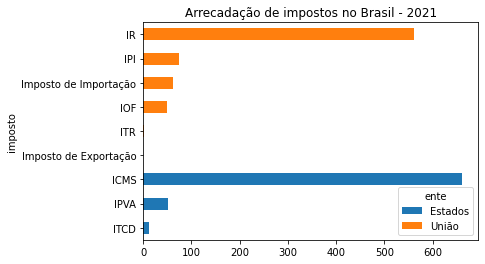

In [22]:
# Gerar gráfico de coluna - Questão 1
dados_q1.sort_values(["Estados", "União"]).plot.barh(stacked = True, title = "Arrecadação de impostos no Brasil - 2021")

<AxesSubplot:ylabel='conta'>

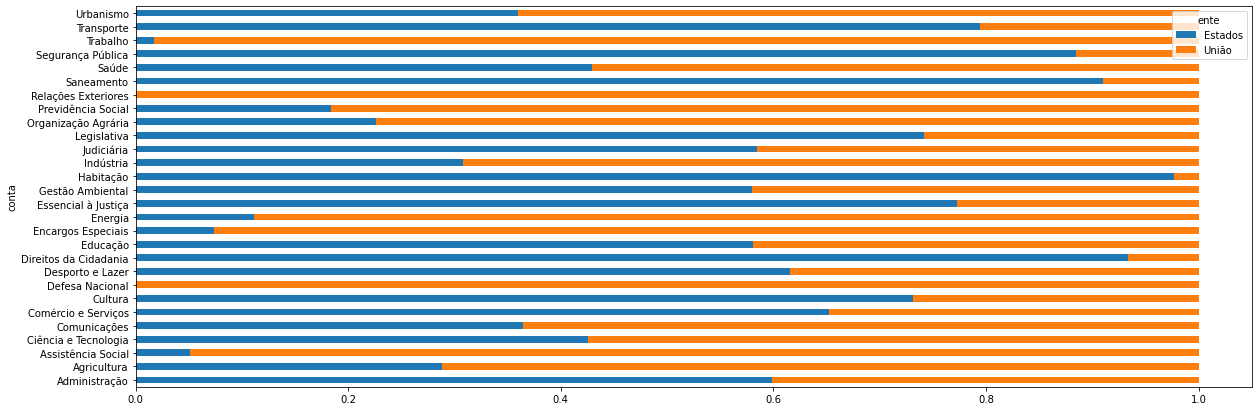

In [31]:
# Gerar gráfico de coluna - Questão 2
dados_q2.sort_values('conta').plot.barh(stacked = True, figsize = (20, 7))